In [1]:
__author__ = "Lisette Espin"
__copyright__ = "Copyright 2019, GESIS / USC-ISI"
__credits__ = ["Lisette Espin-Noboa", 
               "Fariba Karimi",                
               "Claudia Wagner",
               "Markus Strohmaier"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Lisette Espin"
__email__ = "lisette.espin@gesis.org"
__status__ = "Development"

In [2]:
import os
import ast
import operator
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from joblib import Parallel, delayed

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../code')

from org.gesis.libs import io
from org.gesis.libs import viz
from org.gesis.libs import utils
from org.gesis.libs import ranking
from org.gesis.libs.utils import printf
from org.gesis.model.graph import DirectedGraph
from org.gesis.model.graph import get_homophily
from org.gesis.model.DHBA import estimate_homophily_empirical

<h1>Ranking of minorities</h1>

In [4]:
DATASETS = ['aps', 'apsgender3', 'apsgender8', 'github', 'pokec', 'wikipedia'] #'twitter'
ROOT = '../../data/'
OUTPUT = "../../results-batch/"
PLOTS = '../../plots/'

In [5]:
df_summary = None                  # datasets summary properties
df_rank_empirical = None           # fraction of minorities in top-k rank (empirical networks)

<h2>Datasets</h2>

In [6]:
fn = os.path.join(OUTPUT, 'summary_datasets.csv')
df_summary = io.read_csv(fn)
df_summary

,dataset,N,cc,class,m,M,fm,E,Emm,EMM,...,EMm,density,gammaM,kminM,gammam,kminm,hMM,hmm,triadsratio,triadspdf
0,APS,1853,173,pacs,05.20.-y,05.30.-d,0.38,3638,0.294,0.650,...,0.029,0.00106,2.880254,4.0,5.020234,5.0,0.95,0.93,7.741234e-07,"[0.0, 0.2602935911206588, 0.0, 0.6942355889724..."
1,APSgender3,9679,174,gender,female,male,0.10,174760,0.015,0.818,...,0.085,0.00187,4.913199,105.0,1.830627,11.0,0.82,0.27,6.067675e-06,"[0.0, 0.002463174282732545, 0.0, 0.74432729978..."
2,APSgender8,10059,300,gender,female,male,0.11,183067,0.011,0.829,...,0.080,0.00181,1.855324,13.0,1.914697,11.0,0.50,0.60,2.384959e-05,"[0.0, 0.0006445705130733074, 0.0, 0.7775175926..."
3,Github,296612,6965,gender,female,male,0.06,1723930,0.005,0.899,...,0.051,0.00002,2.847932,60.0,2.661940,21.0,0.55,0.61,2.551588e-10,"[0.00012062479001814398, 0.0006425589775966516..."
4,Pokec,1632636,1,gender,1,0,0.49,30622117,0.195,0.250,...,0.248,0.00001,4.506221,131.0,3.850320,109.0,0.51,0.38,2.853004e-11,"[0.043744452862550076, 0.0685444396945499, 0.0..."
5,Wikipedia,3159,66,gender,female,male,0.15,14890,0.030,0.785,...,0.078,0.00149,3.647207,17.0,2.435874,5.0,0.67,0.58,1.416910e-06,"[0.0009691331104327179, 0.0026166593981683385,..."


<h2>Ranking Empirical</h2>

In [7]:
df_rank_empirical = ranking.rank_empirical(ROOT, df_summary.dataset.unique(), OUTPUT)
df_rank_empirical.head()        

,kind,metric,dataset,gini,mae,epoch,rank,fmt
0,empirical,indegree,APS,0.696307,0.176939,0,5.0,0.000000
1,empirical,indegree,APS,0.696307,0.176939,0,10.0,0.000000
2,empirical,indegree,APS,0.696307,0.176939,0,20.0,0.111111
3,empirical,indegree,APS,0.696307,0.176939,0,30.0,0.166667
4,empirical,indegree,APS,0.696307,0.176939,0,40.0,0.166667


<h2>Plotting Ranks</h2>

In [8]:
df_rank = df_rank_empirical.query("metric in ['pagerank', 'circle_of_trust', 'wtf']").copy()
df_rank.sample(5)

,kind,metric,dataset,gini,mae,epoch,rank,fmt
49,empirical,wtf,APSgender3,0.870278,0.035646,0,50.0,0.062893
33,empirical,circle_of_trust,APSgender3,0.859541,0.008646,0,5.0,0.111111
49,empirical,wtf,Github,0.966548,0.011798,0,50.0,0.088481
40,empirical,circle_of_trust,APSgender8,0.859474,0.018495,0,70.0,0.085714
26,empirical,pagerank,APS,0.445682,0.026539,0,40.0,0.357143


<p style="color:red">Pokec does not have circle_of_trust and wtf ranking for empirical yet</p>

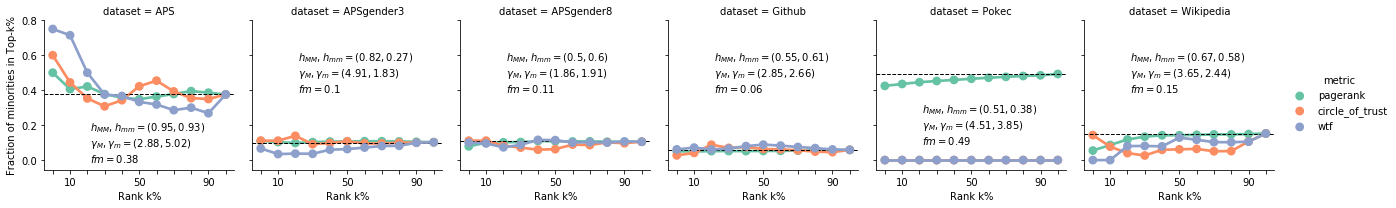

In [9]:
viz.plot_empirical_rankings(df_rank, df_summary, fn=None)

<h1>Best ranking method</h1>

<p style="color:blue">The ranking curve closest to the real fraction of minorities (using mean-absolute-error)</p>

In [10]:
df_mae = ranking.MAE_empirical(df_rank, df_summary)
df_best = ranking.best_ranking_empirical(df_mae)
df_best

,dataset,distance,metric,pvalue
0,APS,0.026137,pagerank,NaN
1,APSgender3,0.005492,pagerank,NaN
2,APSgender8,0.007430,pagerank,NaN
3,Github,0.006922,pagerank,NaN
4,Pokec,0.027902,pagerank,NaN
5,Wikipedia,0.021694,pagerank,NaN


<h2>CDF</h2>

<p style="color:blue">Best curve: the one closest to the real minority fraction fm (vertical dotted line)</p>

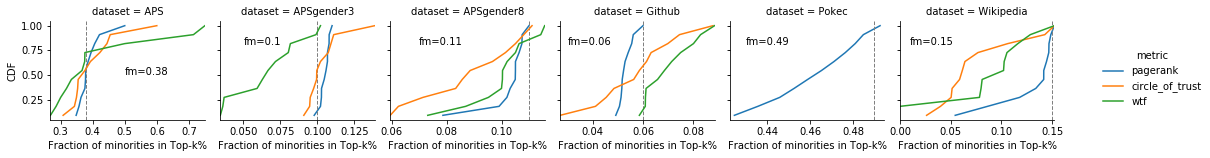

In [11]:
viz.plot_cdf_ranking(df_rank, df_summary)